# Bayesian estimation of the bivariate beta parameter

In [1]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.CRITICAL)

import os
import tqdm
import numpy as np
from scipy import stats
import pandas as pd

from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path
import abcpy

import matplotlib.pyplot as plt
import matplotlib
import arviz as az
plt.style.use('science')

import sys
sys.path.append('../scripts/python')
    
from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [89]:
stanfile = os.path.join('..', 'scripts', 'stan', 'simple_normal_model.stan')
simple_normal_model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True}, 
                                   stanc_options={'O1': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'simple_gamma_model.stan')
simple_gamma_model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True}, 
                                   stanc_options={'O1': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'simple_model.stan')
simple_model = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True}, 
                      stanc_options={'O1': True})

stanfile = os.path.join('..', 'scripts', 'stan', 'bivariate-beta-model-v10.stan')
model10 = CmdStanModel(stan_file=stanfile, cpp_options={'STAN_THREADS': True})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


## Default hyperparameters

Generating the data

In [4]:
def generate_data(true_alpha, n, seed):
    ro = np.random.RandomState(seed=seed)
    U = ro.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    return U[:,0], XY

## Conditioning on the sum of beta random variables

In [65]:
true_alpha = np.array([2.5, 1.0, 1.9, 1.8])
n = 1

rng = np.random.default_rng(seed=903321)
U1 = rng.beta(true_alpha[0], true_alpha[1], size=n)
U2 = rng.beta(true_alpha[2], true_alpha[3], size=n)
 
data = {'x': U1+U2, 'n': n}
data.update(dict(zip('abcd', true_alpha)))

fit = simple_model.sample(data=data, seed=1000, adapt_delta=0.8, iter_sampling=100000, iter_warmup=90000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [7]:
print(fit.diagnose())

Processing csv files: /tmp/tmpumx3aitn/simple_model-20220807142006_1.csv, /tmp/tmpumx3aitn/simple_model-20220807142006_2.csv, /tmp/tmpumx3aitn/simple_model-20220807142006_3.csv, /tmp/tmpumx3aitn/simple_model-20220807142006_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



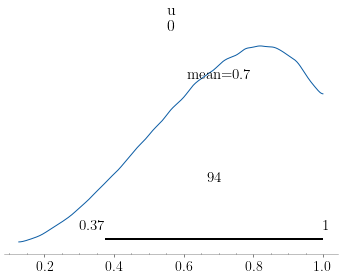

In [9]:
az.plot_posterior(fit)
plt.show()

In [10]:
draws = fit.draws_pd()

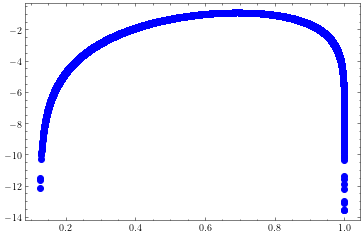

In [12]:
plt.scatter(draws[draws['divergent__'] == 0]['u[1]'], 
            draws[draws['divergent__'] == 0]['lp__'], 
            color='blue')
plt.scatter(draws[draws['divergent__'] == 1]['u[1]'],
            draws[draws['divergent__'] == 1]['lp__'], 
            color='red', alpha=0.05)

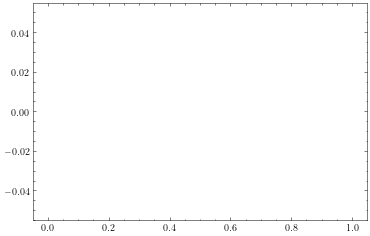

In [14]:
plt.hist(draws[draws['divergent__'] == 1]['u[1]'], bins=50)
plt.show()

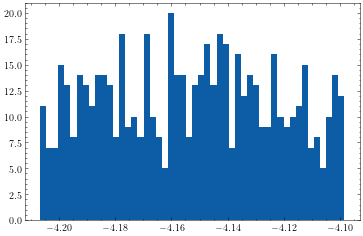

In [15]:
plt.hist(draws[(draws['u[1]'] > 0.99)&(draws['u[1]'] < 0.991)]['lp__'], bins=50)
plt.show()

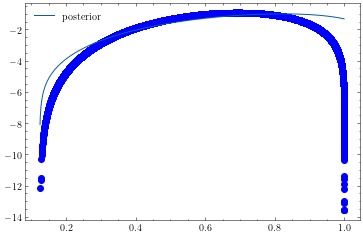

In [17]:
t = np.linspace(U1+U2-1,1,1000,endpoint=False)
plt.plot(t, stats.beta(true_alpha[0], true_alpha[1]).logpdf(t) + \
            stats.beta(true_alpha[2], true_alpha[3]).logpdf(U1+U2-t) - 1.8,
         label='posterior')
plt.scatter(draws[draws['divergent__'] == 0]['u[1]'], 
            draws[draws['divergent__'] == 0]['lp__'], 
            color='blue')
plt.scatter(draws[draws['divergent__'] == 1]['u[1]'],
            draws[draws['divergent__'] == 1]['lp__'], 
            color='red')
plt.legend()
plt.show()

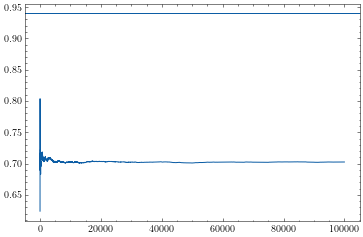

In [18]:
plt.plot(np.cumsum(fit.draws()[:,1,-1])/np.linspace(1, 100000,100000))
plt.axhline(U1)
plt.show()

In [47]:
X

39.43758531252327

## Conditioning on the sum of normal distributions

In [95]:
mu1 = 10
mu2 = -10
sigma1 = 1
sigma2 = 1

X = np.random.normal(mu1, sigma1)
Y = np.random.normal(mu2, sigma2)

data = {'s': X+Y, 'mu1': mu1, 'mu2': mu2, 'sigma1': sigma1, 'sigma2': sigma2}

true_mean = mu1 + sigma1**2/(sigma1**2 + sigma2**2) * (X+Y-(mu2+mu1))
true_std = sigma1 * sigma2 / np.sqrt(sigma1**2 + sigma2**2)
true_x = np.random.normal(true_mean, true_std, size=100000)

In [96]:
fit = simple_normal_model.sample(data=data, iter_sampling=10000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


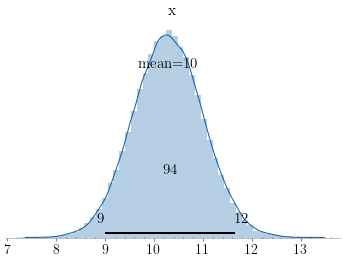

In [97]:
ax = az.plot_posterior(fit)
ax.hist(true_x, bins=50, density=True, alpha=0.3)
plt.show()

## Conditioning on the sum of gamma distributions

In [133]:
alpha1 = 0.2
alpha2 = 0.2
beta1  = 0.2
beta2  = 0.2

X = np.random.gamma(shape=alpha1, scale=1/beta1)
Y = np.random.gamma(shape=alpha2, scale=1/beta2)

data = {'s': X+Y, 'alpha1': alpha1, 'alpha2': alpha2, 'beta1': beta1, 'beta2': beta2}

true_x = (X+Y) * np.random.beta(alpha1, alpha2, size=100000)

In [134]:
fit = simple_gamma_model.sample(data=data, iter_sampling=10000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


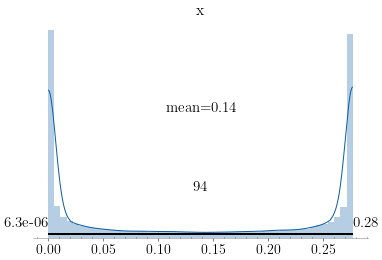

In [135]:
ax = az.plot_posterior(fit)
ax.hist(true_x, bins=50, density=True, alpha=0.3)
plt.show()

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

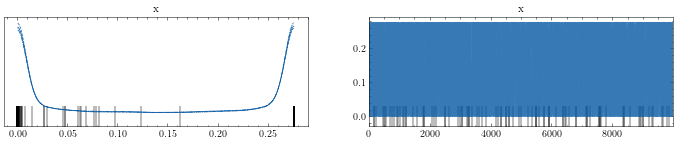

In [136]:
az.plot_trace(fit)